Austin Bicycle Rental Data Analytics

The data set is from https://data.austintexas.gov/dataset/Austin-B-Cycle-Kiosk-Locations/qd73-bsdg
                     https://data.austintexas.gov/dataset/Austin-B-Cycle-Trips/tyfh-5r8s
                     
The project is divided into 4 uses cases:
1.Finding Average Bicycle rental duration.
2.Finding the most and least used kioscks.
3.Finding the best membership plan for walk up members using Kmeans clustiering.
4.Finding the most prefered membership type using Logistic regression.


Credit:Code line 108 to 123 was referred from https://github.com/davidloke/PySparkBCycleAssignment/blob/master/Assignment%20Notebook.ipynb 



In [108]:
#Importing necessary libraries 
#Creating spark context
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName('Bicycle')
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Bicycle").getOrCreate()


In [109]:
sc = SparkContext.getOrCreate(conf=conf)

In [110]:
# Loading the data sets
bcycleKiosk = sc.textFile("C:/Users/karth/Desktop/Bigdata/Austin_B-Cycle_Kiosk_Locations.csv")
bcycleTrips = sc.textFile("C:/Users/karth/Desktop/Bigdata/Austin_B-Cycle_Trips.csv")

# Remove Header from bcycleKiosk,bcycleTrips
kioskHeader = bcycleKiosk.first()
bcycleKioskNoHeader = bcycleKiosk.filter(lambda line: line != kioskHeader)
tripHeader = bcycleTrips.first()
bcycleTripsNoHeader = bcycleTrips.filter(lambda line: line != tripHeader)
bcycleTripsNoHeader.take(5)

# Credit from https://community.hortonworks.com/questions/113255/removing-header-from-csv-file-through-pyspark.html

['9900285854,Annual (San Antonio B-cycle),207,10/26/2014,13:12:00,2537,West & 6th St.,2707,Rainey St @ Cummings,76,10,2014',
 '9900285855,24-Hour Kiosk (Austin B-cycle),969,10/26/2014,13:12:00,2498,Convention Center / 4th St. @ MetroRail,2566,Pfluger Bridge @ W 2nd Street,58,10,2014',
 '9900285856,Annual Membership (Austin B-cycle),214,10/26/2014,13:12:00,2537,West & 6th St.,2496,8th & Congress,8,10,2014',
 '9900285857,24-Hour Kiosk (Austin B-cycle),745,10/26/2014,13:12:00,,Zilker Park at Barton Springs & William Barton Drive,,Zilker Park at Barton Springs & William Barton Drive,28,10,2014',
 '9900285858,24-Hour Kiosk (Austin B-cycle),164,10/26/2014,13:12:00,2538,Bullock Museum @ Congress & MLK,,Convention Center/ 3rd & Trinity,15,10,2014']

In [111]:
bcycleKioskNoHeader.take(5)

['2504,South Congress & Elizabeth,active,30.24891,-97.75019,"(30.24891, -97.75019)"',
 '2536,Waller & 6th St.,closed,30.26461,-97.73049,"(30.26461, -97.73049)"',
 '2537,West & 6th St.,active,30.27041,-97.75046,"(30.27041, -97.75046)"',
 '2538,Bullock Museum @ Congress & MLK,active,30.28039,-97.73809,"(30.28039, -97.73809)"',
 '2539,Convention Center / 3rd & Trinity,active,30.26426,-97.74023,"(30.26426, -97.74023)"']

In [112]:

period = '2016'

# Extract only required fields for the year 2016: bicycle_id, checkout_date, and trip_duration_minutes fields
bcycleTripsNoHeaderIn2016 = bcycleTripsNoHeader.map(lambda line: line.split(",")).filter(lambda fields: fields[11] == period).filter(lambda fields: len(fields[2])>0)
bcycleTripsNoHeaderIn2016.take(5)
bcycleTripPerBikeDate = bcycleTripsNoHeaderIn2016.filter(lambda fields: int(fields[9]) > 0).map(lambda fields:((fields[2],fields[3]),fields[9]))

# Total trip duration per bike, per day
bcycleTripPerBikeDateTotalTrip = bcycleTripPerBikeDate.reduceByKey(lambda v1, v2: int(v1) + int(v2))

# Creation of rdd using flatmapvalue to get 2 records per trip: (bike_id, checkout_date) and (bike_id,trip_duration_minutes)
bcycleTripPerBikeDateTotalTripKeyByBikeDate = bcycleTripPerBikeDateTotalTrip.flatMapValues(lambda x : str(x)).map(lambda line: (line[0][0],[line[0][1],line[1]]))
bcycleTripPerBikeFlatMap = bcycleTripPerBikeDateTotalTripKeyByBikeDate.flatMapValues(lambda x: x)
tupleBikeDate = bcycleTripPerBikeFlatMap.filter(lambda line: "/" in line[1])
tupleBikeDuration = bcycleTripPerBikeFlatMap.filter(lambda line: "/" not in line[1])

# Sum the total trip duration
tupleBikeSumDurationKeyBikeId = tupleBikeDuration.reduceByKey(lambda v1, v2: str(int(v1) + int(v2)))

# total number of trips 
tupleBikeSumTripsKeyBikeId = tupleBikeDate.map(lambda fields: (fields[0],1)).reduceByKey(lambda v1, v2: str(int(v1) + int(v2)))

# Produce the Expected Output Format: (bike_id, number_of_trips, total_trip_duration, avg_rental_duration)
expectedOutputFormat = tupleBikeSumTripsKeyBikeId.join(tupleBikeSumDurationKeyBikeId).map(lambda x: (int(x[0]),[x[1][0],x[1][1],int(x[1][1])/float(x[1][0])]))

# Scenario A: Find the top 5 highest average rental duration
expectedOutputFormat.sortBy((lambda fields: fields[1][2]),False)

# Scenario B: Find the bicycle with the most number of trips 
expectedOutputFormat.sortBy((lambda fields: fields[1][0]),False)

PythonRDD[281] at RDD at PythonRDD.scala:48

In [113]:
import pyspark.sql.functions as func

In [114]:
#creating the Schema for the Trips Data Frame 
from pyspark.sql.types import *
trip_schema = StructType( [
    StructField('trip_id', StringType(), True),
    StructField('membership_type', StringType(), True),
    StructField('bicycle_id', StringType(), True),
    StructField('checkout_date', StringType(), True),
    StructField('checkout_time', StringType(), True),
    StructField('checkout_kiosk_id', StringType(), True),
    StructField('checkout_kiosk', StringType(), True),
    StructField('return_kiosk_id', StringType(), True),
    StructField('return_kiosk', StringType(), True),
    StructField('trip_duration_minutes', StringType(), True),
    StructField('month', StringType(), True),
    StructField('year', StringType(), True) ])
#creating the Schema for the Kiosk Data Frame 
kiosk_schema = StructType( [
    StructField('kiosk_id', StringType(), True),
    StructField('kiosk_name', StringType(), True),
    StructField('kiosk_status', StringType(), True),
    StructField('latitude', StringType(), True),
    StructField('longitude', StringType(), True),
    StructField('location', StringType(), True) ])

# Create the Data Frame for Trips and Kiosk
trips = spark.read.csv("C:/Users/karth/Desktop/Bigdata/Austin_B-Cycle_Trips.csv", header=False, nullValue="na", schema=trip_schema)
kiosks = spark.read.csv("C:/Users/karth/Desktop/Bigdata/Austin_B-Cycle_Kiosk_Locations.csv", header=False, nullValue="na", schema=kiosk_schema)

# Choosing records from March 2016 
trips2016 = trips.filter('year == 2016').filter('month == 3')

# Count the number of checkin and checkout activities that each kiosk experienced
trips2016Checkout = trips2016.groupBy('checkout_kiosk_id').agg({'checkout_kiosk_id': 'count'})
trips2016Checkin = trips2016.groupBy('return_kiosk_id').agg({'return_kiosk_id': 'count'})

#Top 3 kiosks for checkout/checkin activity
top3Checkout = trips2016Checkout.orderBy('count(checkout_kiosk_id)', ascending = False).limit(3)
top3Checkin = trips2016Checkin.orderBy('count(return_kiosk_id)', ascending = False).limit(3)

#Bottom 3 kiosks for checkout/checkin activity
bottom3Checkout = trips2016Checkout.orderBy('count(checkout_kiosk_id)', ascending = True).limit(3)
bottom3Checkin = trips2016Checkin.orderBy('count(return_kiosk_id)', ascending = True).limit(3)

#Show the distinct kiosks that have the LEAST checkout/checkin activity 
bottom3Union = bottom3Checkin.unionAll(bottom3Checkout).select('return_kiosk_id').selectExpr('return_kiosk_id as kiosk_id_least_activity').distinct()
bottom3Union.join(kiosks, bottom3Union.kiosk_id_least_activity == kiosks.kiosk_id).select('kiosk_id_least_activity', "kiosk_name").show()




+-----------------------+--------------------+
|kiosk_id_least_activity|          kiosk_name|
+-----------------------+--------------------+
|                   2561|State Capitol Vis...|
|                   2823|Capital Metro HQ ...|
|                   3293|East 2nd & Pedern...|
|                   3381|East 7th & Pleasa...|
+-----------------------+--------------------+



In [115]:
# Distinct kiosks that have the MOST checkout/checkin activity 
top3Union = top3Checkin.unionAll(top3Checkout).select('return_kiosk_id').selectExpr('return_kiosk_id as kiosk_id_most_activity').distinct()
top3Union.join(kiosks, top3Union.kiosk_id_most_activity == kiosks.kiosk_id).select('kiosk_id_most_activity', "kiosk_name").show()


+----------------------+--------------------+
|kiosk_id_most_activity|          kiosk_name|
+----------------------+--------------------+
|                  2539|Convention Center...|
|                  2498|Convention Center...|
|                  2563|Davis at Rainey S...|
+----------------------+--------------------+



### K Means Clustering 

In [116]:
# Loading the dataset
bcycleCust = sc.textFile("C:/Users/karth/Desktop/Bigdata/Austin_B-Cycle_Trips1.csv")



In [117]:
bcycleCust.max()

'Trip_ID,Membership_Type,Bicycle_ID,Checkout_Date,Checkout_Time,Checkout_Kiosk_ID,Checkout_Kiosk,Return_Kiosk ID,Return_Kiosk,Trip_Duration Minutes,Month,Year,Age_Range,Gender,Payment_Type'

In [118]:
# Removing the Header for bcycleKiosk 
custHeader = bcycleCust.first()
bcycleCustNoHeader = bcycleCust.filter(lambda line: line != custHeader)

# Filter only 2016 records 
bcycleCust2016 = bcycleCustNoHeader.map(lambda line: line.split(','))

# Choosing features of interest: membership_type, age_range, gender, payment_type
bcycleCust2016Fields = bcycleCust2016.map(lambda fields: [fields[1],fields[12],fields[13],fields[14]])

# Exclude the walk-up members - cause we want to sell membership to them! 
bcycleCust2016Members = bcycleCust2016Fields.filter(lambda fields: fields[0] != 'Walk Up')



In [14]:
bcycleCust2016Members.take(50)

[['Local365', 'below21', 'Male', 'visa'],
 ['Local365', 'below21', 'Female', 'visa'],
 ['Local365', 'below21', 'Male', 'mastercard'],
 ['Local365', '21 to 25', 'Female', 'mastercard'],
 ['Local365', '36 to 50', 'Male', 'amex'],
 ['Local365', '51 to 65', 'Female', 'mastercard'],
 ['Local365', '51 to 65', 'Female', 'visa'],
 ['Local365', '21 to 25', 'Male', 'unionpay'],
 ['Local365', '21 to 25', 'Male', 'amex'],
 ['Local365', '36 to 50', 'Male', 'unionpay'],
 ['Local365', '51 to 65', 'Female', 'others'],
 ['Local365', '51 to 65', 'Male', 'mastercard'],
 ['Local365', '36 to 50', 'Male', 'amex'],
 ['Local30', 'below21', 'Female', 'visa'],
 ['Local365', 'below21', 'Female', 'unionpay'],
 ['Local30', 'above 65', 'Female', 'mastercard'],
 ['Local365', '21 to 25', 'Female', 'mastercard'],
 ['Local365', 'below21', 'Female', 'amex'],
 ['Local365', '36 to 50', 'Female', 'amex'],
 ['Local30', 'above 65', 'Male', 'amex'],
 ['Local365', '51 to 65', 'Female', 'amex'],
 ['Local365', '36 to 50', 'Femal

In [119]:
# Conversion of string variables into int variables to suit our model better.
def preprocessClustingData(fields):
    membershipInt = 0;
    ageInt = 0;
    genderInt = 0;
    paymentInt = 0;
    
    # Convert membership string
    if (fields[0] == 'Walk Up'):
        membershipInt = 0.0
    elif (fields[0] == 'Weekender'): 
        membershipInt = 1.0
    elif (fields[0] == 'Local30'): 
        membershipInt = 2.0
    elif (fields[0] == 'Local365'): 
        membershipInt = 3.0
    else: 
        membershipInt = 4.0
        
    # Convert age string
    if (fields[1] == 'below 21'):
        ageInt = 0.0
    elif (fields[1] == '21 to 35'): 
        ageInt = 1.0
    elif (fields[1] == '36 to 50'): 
        ageInt = 2.0
    elif (fields[1] == '51 to 65'): 
        ageInt = 3.0
    elif (fields[1] == 'above 65'): 
        ageInt = 4.0
    
    # Convert gender string
    if (fields[2] == 'male'):
        genderInt = 0.0
    else: 
        genderInt = 1.0
    
    # Convert payment string
    if (fields[3] == 'visa'):
        paymentInt = 0.0
    elif (fields[3] == 'mastercard'): 
        paymentInt = 1.0
    elif (fields[3] == 'amex'): 
        paymentInt = 2.0
    elif (fields[3] == 'unionpay'): 
        paymentInt = 3.0
    elif (fields[3] == 'others'): 
        paymentInt = 4.0

    return [membershipInt,ageInt,genderInt,paymentInt]
        
# Mapping the preprocess data to the actual dataset
bcycleCust2016FieldsPreprocessed = bcycleCust2016Members.map(preprocessClustingData)



In [120]:
bcycleCust2016FieldsPreprocessed.max()

[4.0, 4.0, 1.0, 4.0]

In [121]:
# Build the model (cluster the data)
from pyspark.mllib.clustering import KMeans
model = KMeans.train(bcycleCust2016FieldsPreprocessed, 10, maxIterations=20, initializationMode='random')

# Printing the center of the clusters 
clusterMembership = []
for cluster in model.clusterCenters:
    recommended = round(cluster[0])
    if (recommended == 1.0):
        clusterMembership.append('Weekender')
    elif (recommended == 2.0):
        clusterMembership.append('Local30')
    else: 
        clusterMembership.append('Local365')

print (clusterMembership)

['Local365', 'Local365', 'Local365', 'Local30', 'Weekender', 'Local365', 'Local365', 'Local365']


In [122]:
# Select walk up customers of bcycle in 2016
bcycleCust2016WalkUp = bcycleCust2016Fields.filter(lambda fields: fields[0] == 'Walk Up')

# Preprocess the data from string to int, and select 10 records for illustration
bcycleCust2016WalkUpPreprocessed = bcycleCust2016WalkUp.map(preprocessClustingData)
bcycleCust2016WalkUpPreprocessedSubset = bcycleCust2016WalkUpPreprocessed.take(100)

for record in bcycleCust2016WalkUpPreprocessedSubset:
    cluster = model.predict(record)
    print(record, '-->', clusterMembership[model.predict(record)])

[0.0, 2.0, 1.0, 3.0] --> Weekender
[0.0, 2.0, 1.0, 4.0] --> Weekender
[0.0, 2.0, 1.0, 1.0] --> Local30
[0.0, 0, 1.0, 4.0] --> Weekender
[0.0, 0, 1.0, 2.0] --> Weekender
[0.0, 2.0, 1.0, 4.0] --> Weekender
[0.0, 0, 1.0, 1.0] --> Weekender
[0.0, 2.0, 1.0, 1.0] --> Local30
[0.0, 4.0, 1.0, 2.0] --> Local365
[0.0, 2.0, 1.0, 4.0] --> Weekender
[0.0, 4.0, 1.0, 1.0] --> Local365
[0.0, 4.0, 1.0, 4.0] --> Local365
[0.0, 0, 1.0, 1.0] --> Weekender
[0.0, 0, 1.0, 3.0] --> Weekender
[0.0, 0, 1.0, 2.0] --> Weekender
[0.0, 3.0, 1.0, 0.0] --> Local30
[0.0, 3.0, 1.0, 4.0] --> Local365
[0.0, 4.0, 1.0, 4.0] --> Local365
[0.0, 3.0, 1.0, 2.0] --> Local365
[0.0, 0, 1.0, 4.0] --> Weekender
[0.0, 3.0, 1.0, 3.0] --> Local365
[0.0, 3.0, 1.0, 3.0] --> Local365
[0.0, 0, 1.0, 3.0] --> Weekender
[0.0, 0, 1.0, 1.0] --> Weekender
[0.0, 2.0, 1.0, 0.0] --> Local30
[0.0, 2.0, 1.0, 2.0] --> Weekender
[0.0, 0, 1.0, 0.0] --> Local365
[0.0, 0, 1.0, 3.0] --> Weekender
[0.0, 2.0, 1.0, 3.0] --> Weekender
[0.0, 2.0, 1.0, 4.0] -->

### Data Exploration and Visualizations

In [129]:
#Loading the dataset as pandas dataframe for exploratory data analysis and visualization 
df4 = pd.read_csv('C:/Users/karth/Desktop/Bigdata/Austin_B-Cycle_Trips3.csv')
df4.head()

,Trip_ID,Membership_Type,Bicycle_ID,Checkout_Date,Checkout_Time,Checkout_Kiosk_ID,Checkout_Kiosk,Return_Kiosk ID,Return_Kiosk,Trip_Duration Minutes,Month,Year,Age_Range,Gender,Payment_Type
0,12976114,Local365,329.0,11/25/2016,20:57:51,3390.0,Brazos & 6th,2552.0,3rd & West,7,11,2016,below21,Male,visa
1,12863382,Local365,924.0,11/16/2016,19:19:06,2552.0,3rd & West,2501.0,5th & Bowie,1,11,2016,below21,Female,visa
2,12814142,Local365,991.0,11/13/2016,16:08:04,2552.0,3rd & West,2575.0,Riverside @ S. Lamar,25,11,2016,below21,Male,mastercard
3,12792474,Local365,666.0,11/11/2016,16:57:54,3390.0,Brazos & 6th,2501.0,5th & Bowie,10,11,2016,21 to 25,Female,mastercard
4,12766250,Local365,478.0,11/10/2016,7:21:01,2542.0,Plaza Saltillo,2542.0,Plaza Saltillo,0,11,2016,36 to 50,Male,amex


In [128]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline


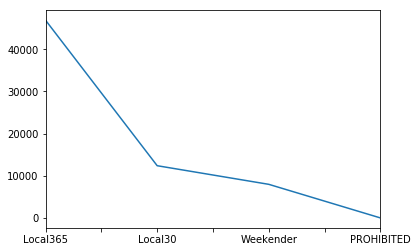

In [130]:
#Plotting Membership type count.
df4['Membership_Type'].value_counts().plot()

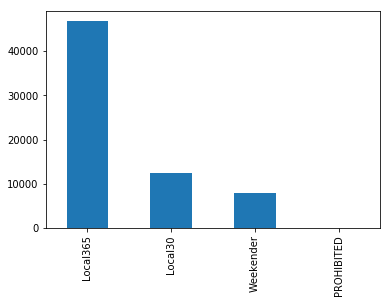

In [131]:
#Plotting Membership type count.
df4['Membership_Type'].value_counts().plot('bar')

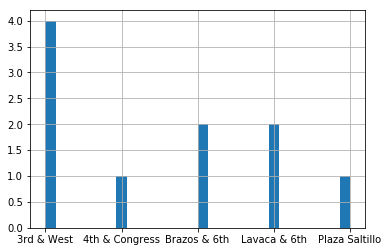

In [132]:
#Plotting the most used kiosk for checkout.
df4['Checkout_Kiosk'][:10].hist(bins = 30) 

### Logistic Regression

In [124]:
# Reading the dataset for Logitic regression
bcycleCust1 = sc.textFile("C:/Users/karth/Desktop/Bigdata/Austin_B-Cycle_Trips3.csv")
rdd1 = bcycleCust1.map(lambda line: line.split(","))

In [125]:
#Viewing the imported data
rdd1.take(2)

[['Trip_ID',
  'Membership_Type',
  'Bicycle_ID',
  'Checkout_Date',
  'Checkout_Time',
  'Checkout_Kiosk_ID',
  'Checkout_Kiosk',
  'Return_Kiosk ID',
  'Return_Kiosk',
  'Trip_Duration Minutes',
  'Month',
  'Year',
  'Age_Range',
  'Gender',
  'Payment_Type'],
 ['12976114',
  'Local365',
  '329',
  '11/25/2016',
  '20:57:51',
  '3390',
  'Brazos & 6th',
  '2552',
  '3rd & West',
  '7',
  '11',
  '2016',
  'below21',
  'Male',
  'visa']]

In [126]:
#removing the dataset header
header = rdd1.first()
rdd1 = rdd1. filter(lambda line:line != header)

In [127]:
rdd1.take(2)

[['12976114',
  'Local365',
  '329',
  '11/25/2016',
  '20:57:51',
  '3390',
  'Brazos & 6th',
  '2552',
  '3rd & West',
  '7',
  '11',
  '2016',
  'below21',
  'Male',
  'visa'],
 ['12863382',
  'Local365',
  '924',
  '11/16/2016',
  '19:19:06',
  '2552',
  '3rd & West',
  '2501',
  '5th & Bowie',
  '1',
  '11',
  '2016',
  'below21',
  'Female',
  'visa']]

In [133]:
# Choosing the features of interest: membership_type, age_range, gender, payment_type
rdd1 = rdd1.map(lambda fields: [fields[1],fields[12],fields[13],fields[14]])

In [134]:
# Python function to convert from predefined string to int 
def preprocessClustingData1(fields):
    membershipInt = 0;
    ageInt = 0;
    genderInt = 0;
    paymentInt = 0;
    
    # Convert membership string
    if (fields[0] == 'Weekender'):
        membershipInt = 0.0
    elif (fields[0] == 'Local30'): 
        membershipInt = 1.0
    elif (fields[0] == 'Local365'): 
        membershipInt = 2.0
    elif (fields[0] == 'PROHIBITED'): 
        membershipInt = 3.0
    else: 
        membershipInt = 4.0
        
    # Convert age string
    if (fields[1] == 'below 21'):
        ageInt = 0.0
    elif (fields[1] == '21 to 35'): 
        ageInt = 1.0
    elif (fields[1] == '36 to 50'): 
        ageInt = 2.0
    elif (fields[1] == '51 to 65'): 
        ageInt = 3.0
    elif (fields[1] == 'above 65'): 
        ageInt = 4.0
    else:
        ageInt=5.0
    
    # Convert gender string
    if (fields[2] == 'male'):
        genderInt = 0.0
    else: 
        genderInt = 1.0
    
    # Convert payment string
    if (fields[3] == 'visa'):
        paymentInt = 0.0
    elif (fields[3] == 'mastercard'): 
        paymentInt = 1.0
    elif (fields[3] == 'amex'): 
        paymentInt = 2.0
    elif (fields[3] == 'unionpay'): 
        paymentInt = 3.0
    elif (fields[3] == 'others'): 
        paymentInt = 4.0

    return [membershipInt,ageInt,genderInt,paymentInt]
        
# Preprocess the data - convert from string to int 
rdd12 = rdd1.map(preprocessClustingData1)



In [135]:
rdd12.take(2)

[[2.0, 5.0, 1.0, 0.0], [2.0, 5.0, 1.0, 0.0]]

In [136]:
#Converting the dataset into pandas for processing
from pyspark.sql import Row
df3 = rdd12.map(lambda line:Row(Membership_type = line[0],  Age=line[1], Gender =line[2], Payment_type =line[3],)).toDF()
df3.toPandas().head()


,Age,Gender,Membership_type,Payment_type
0,5.0,1.0,2.0,0.0
1,5.0,1.0,2.0,0.0
2,5.0,1.0,2.0,1.0
3,5.0,1.0,2.0,1.0
4,2.0,1.0,2.0,2.0


In [137]:
#Selecting the required fields in the desired order.
df3=df3.select('Membership_type','Age','Gender','Payment_type')

In [138]:
#Viewing the schema
df3.printSchema()

root
 |-- Membership_type: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Gender: double (nullable = true)
 |-- Payment_type: double (nullable = true)



In [139]:
#Import necessary librabires for analysis 
import pyspark.mllib
import pyspark.mllib.regression
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import * 
import numpy as np

In [140]:
#Converting the data into labelled points
temp = df3.rdd.map(lambda line: LabeledPoint(line[0],[line[1:]]))


In [141]:
#Viewing the data labelled points
temp.take(15)

[LabeledPoint(2.0, [5.0,1.0,0.0]),
 LabeledPoint(2.0, [5.0,1.0,0.0]),
 LabeledPoint(2.0, [5.0,1.0,1.0]),
 LabeledPoint(2.0, [5.0,1.0,1.0]),
 LabeledPoint(2.0, [2.0,1.0,2.0]),
 LabeledPoint(2.0, [3.0,1.0,1.0]),
 LabeledPoint(2.0, [3.0,1.0,0.0]),
 LabeledPoint(2.0, [5.0,1.0,3.0]),
 LabeledPoint(2.0, [5.0,1.0,2.0]),
 LabeledPoint(2.0, [2.0,1.0,3.0]),
 LabeledPoint(2.0, [3.0,1.0,4.0]),
 LabeledPoint(2.0, [3.0,1.0,1.0]),
 LabeledPoint(2.0, [2.0,1.0,2.0]),
 LabeledPoint(1.0, [5.0,1.0,0.0]),
 LabeledPoint(2.0, [5.0,1.0,3.0])]

In [142]:
#Importing necessary libraries for feature scaling and transformation
from pyspark.mllib.util import MLUtils
from pyspark.mllib.linalg import Vectors
from pyspark.ml.linalg import Vectors
from pyspark.mllib.feature import StandardScaler

In [143]:
#Selecting the independant variables
features = df3.rdd.map(lambda row: row[1:])

In [144]:
#Viewing the selected features
features.take(1)

[(5.0, 1.0, 0.0)]

In [146]:
#Feature scaling and transformation
standardizer = StandardScaler()
model = standardizer.fit(features)
features_transform = model.transform(features)

In [147]:
#Viewing the features
features_transform.take(5)

[DenseVector([4.2338, 0.0, 0.0]),
 DenseVector([4.2338, 0.0, 0.0]),
 DenseVector([4.2338, 0.0, 0.6946]),
 DenseVector([4.2338, 0.0, 0.6946]),
 DenseVector([1.6935, 0.0, 1.3893])]

In [148]:
#Choosing the dependant variables
labels = df3.rdd.map(lambda row: row[0])
labels.take(5)

[2.0, 2.0, 2.0, 2.0, 2.0]

In [150]:
#Combining the dependant and independant variables
transformedData = labels.zip(features_transform)
transformedData.take(5)

[(2.0, DenseVector([4.2338, 0.0, 0.0])),
 (2.0, DenseVector([4.2338, 0.0, 0.0])),
 (2.0, DenseVector([4.2338, 0.0, 0.6946])),
 (2.0, DenseVector([4.2338, 0.0, 0.6946])),
 (2.0, DenseVector([1.6935, 0.0, 1.3893]))]

In [151]:
transformedData = transformedData.map(lambda row : LabeledPoint(row[0],row[1]))
transformedData.take(5)
type(transformedData)

pyspark.rdd.PipelinedRDD

In [153]:
#Split into train and test data
trainingData, testingData = transformedData.randomSplit([.8,.2])


In [155]:
#Importing the logistic regression and evaluation metrics
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics

In [156]:
#Defining the model
linearModel = LogisticRegressionWithLBFGS.train(trainingData, numClasses=4)

In [157]:
#Weights of the model
linearModel.weights

DenseVector([0.122, 0.0, 0.0338, 0.4443, 0.0, 0.1858, -2.7913, 0.0, -0.4374])

In [158]:
#Viewing the test data
testingData.take(10)

[LabeledPoint(2.0, [4.23380281638,0.0,0.0]),
 LabeledPoint(2.0, [1.69352112655,0.0,1.38926672637]),
 LabeledPoint(2.0, [1.69352112655,0.0,1.38926672637]),
 LabeledPoint(1.0, [4.23380281638,0.0,0.0]),
 LabeledPoint(2.0, [4.23380281638,0.0,0.694633363187]),
 LabeledPoint(2.0, [2.54028168983,0.0,1.38926672637]),
 LabeledPoint(2.0, [3.3870422531,0.0,2.77853345275]),
 LabeledPoint(2.0, [1.69352112655,0.0,0.694633363187]),
 LabeledPoint(1.0, [4.23380281638,0.0,0.694633363187]),
 LabeledPoint(2.0, [3.3870422531,0.0,2.08390008956])]

In [159]:
#Predicting the Membership type depending on the age gender and payment type
linearModel.predict([5,1,3])

2

In [162]:
#Mapping prediction with features and labels for evaluating our model
predictionAndLabels = testingData.map(lambda lp: (float(linearModel.predict(lp.features)), lp.label))

In [163]:
#Defining evaluation metrics
metrics = MulticlassMetrics(predictionAndLabels)

In [164]:
#Calling the metric values
recall = metrics.recall()
f1Score = metrics.fMeasure()


In [165]:
#Printing the metric values,Accuracy of the model
print("Summary Stats")
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

Summary Stats
Recall = 0.6956393635827932
F1 Score = 0.6956393635827932


Insights:
1. From the visualizations we could make out that there are no individuals or customers who were prohibited from receiving any kind of memberships. 
1. From Logistic regression the most membership given out based on age, paymnet type and gender is Local 365 which means that the local people rent bicycle more frequently 
2. From K means clustering it is evident that most recommended membership type based on age, paymnet type and gender is Local 365 which means that the local people rent bicycle more frequently 
3. The average rental duration is 4.2 days approximately.
4. The most activity of the bicycle is concentrated in Kiosks Convention Center, Davis at Rainey S which are in the more busy parts of the city.


### Recommendations 

1. As we found the most used Kiosks this will be valuable to the operations team to rotate bicycles accordingly and concentrate more inventory of cycles in these kiosks 
2. Similar to the above point we found the lowest used kiosks for checkouts which can be valuable insights for the startegy and marketing team to focus more on sales and increase the rentals by using various marketing strategies 
3. As the most recommended membership predicted by the models are Local 365 this will give the management team and marketing team valuable data to retain customers and to churn more with respect to age, gender and payment type.
4. The model prediction also generated better insights for the most suitable and recommended membership is Local 365 for walk up customers which will help the strategy team to concentrate on the features which affected the most for this and can make tweaks to the existing membership priviliges to make the membership more attractive for customer retaining.  